<a href="https://colab.research.google.com/github/dookda/cmu_py499/blob/main/gee_meji_usc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !conda update -c conda-forge earthengine-api
# !pip install geemap folium earthengine-api 
# !pip install matplotlib pandas numpy seaborn folium 

# Authenticate and initialize the Earth Engine API
import ee

# Provide your Google Cloud project ID
project_id = 'ee-mejichayada2546'

# Authenticate and initialize the Earth Engine API with the project ID
ee.Authenticate()
ee.Initialize(project=project_id)




Successfully saved authorization token.


In [2]:
import folium
map_center = [18.80, 99]
f = folium.Figure(height=400)
m = folium.Map(location=map_center, zoom_start=12).add_to(f)

hex150 = ee.FeatureCollection("projects/ee-mejichayada2546/assets/hex150");
site = hex150.geometry().bounds()

def get_min(img, geom):
    min_val = img.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()
    return min_val['constant']

def get_max(img, geom):
    max_val = img.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()
    return max_val['constant']

def create_image(z_state, col):
    empty = ee.Image().byte()
    img_paint = empty.paint(featureCollection=z_state, color=col)
    return img_paint

def rename_fnc(feat, new_name):
    mean_value = feat.get('mean')
    n_name = feat.set(new_name, mean_value).set('mean', None)
    return n_name

def zonal_state(image, hex, param_name):
    zstat = image.reduceRegions(collection=hex, reducer=ee.Reducer.mean(), scale=30)
    new_feat = zstat.map(lambda feat: rename_fnc(feat, param_name))
    return new_feat

def get_collection(start_date, end_date, week_number, year):
    NDVI = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
          .filterDate(start_date, end_date) \
          .filterBounds(site) \
          .median() \
          .normalizedDifference(['B8', 'B4'])
          
    CO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO") \
          .filterDate(start_date, end_date) \
          .filterBounds(site) \
          .select('CO_column_number_density') \
          .median()

    SO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2") \
            .filterDate(start_date, end_date) \
            .filterBounds(site) \
            .select('SO2_column_number_density') \
            .median()
            
    NO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
            .filterDate(start_date, end_date) \
            .filterBounds(site) \
            .select('NO2_column_number_density') \
            .median()
            
    O3 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_O3") \
            .filterDate(start_date, end_date) \
            .filterBounds(site) \
            .select('O3_column_number_density') \
            .median()
  
    co_z_stat = zonal_state(CO, hex150, 'co')
    so2_z_stat = zonal_state(SO2, co_z_stat, 'so2')
    no2_z_stat = zonal_state(NO2, so2_z_stat, 'no2')
    o3_z_stat = zonal_state(O3, no2_z_stat, 'o3')
    ndvi_z_stat = zonal_state(NDVI, o3_z_stat, 'ndvi')

    export_task = ee.batch.Export.table.toDrive(
        collection = ndvi_z_stat,
        description = 'zonal_statistics',
        folder ='geepy',
        fileNamePrefix =str(year) + "-" + str(week_number),
        fileFormat='CSV'
    )
    export_task.start()

    return ndvi_z_stat

google_satellite = folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

def showMap(feat, geom, param):
  empty = ee.Image().byte()
  imageUsc = empty.paint( featureCollection=feat, color=param)
  visualization = {
      'min': get_min(imageUsc, geom),
      'max': get_max(imageUsc, geom),
      'palette': ['green', 'yellow', 'red']
  }

  map_id_dict = ee.Image(imageUsc).getMapId(visualization)
  folium.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=param,
      overlay=True,
      control=True,
      opacity=0.5
  ).add_to(m)



In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# def get_week_dates(year, week_number):
#     jan_first = ee.Date.fromYMD(year, 1, 2)
#     first_date_of_week = jan_first.advance((week_number - 1) * 7, 'day')
#     last_date_of_week = first_date_of_week.advance(6, 'day')
  
#     return {'first': first_date_of_week, 'last': last_date_of_week}
# Example usage
year = 2022
week_number = 1
week_dates = get_week_dates(year, week_number)


print(week_dates['first'].format('YYYY-MM-dd').getInfo(), week_dates['last'].format('YYYY-MM-dd').getInfo())

feature = get_collection(week_dates['first'].format('YYYY-MM-dd').getInfo(), 
               week_dates['last'].format('YYYY-MM-dd').getInfo() + 'T23:59:00',
               week_number,
               year)

# showMap(feature, site, 'usc')
# showMap(feature, site, 'no2')
# showMap(feature, site, 'ndvi')
# showMap(feature, site, 'lst')
# showMap(feature, site, 'o3')

# folium.LayerControl().add_to(m)
# m

NameError: name 'ee' is not defined

In [ ]:
file_path = 'G:/My Drive/geepy_hex100/'+str(year) + "-" + str(week_number) + '.csv'
df = pd.read_csv(file_path)

year = 2024
week_number = 1
# week_dates = get_week_dates(year, week_number)
# print(df.columns)
columns_of_interest = ['usc', 'co', 'no2', 'o3', 'so2', 'ndvi', 'road_w', 'bd_h']

correlation_matrix = df[columns_of_interest].corr()
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
## export flie correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
year = 2022
week_number =7
# Assuming you've already defined year and week_number
file_path = 'G:/My Drive/geepy_hex100/'+str(year) + "-" + str(week_number) + '.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Columns of interest for correlation analysis
columns_of_interest = ['usc', 'co', 'no2', 'o3', 'so2', 'ndvi']

# Calculate correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# # Define the output folder
# output_folder = 'D:/py499/gee_usc'

# # Save the correlation matrix as an Excel file in the specified folder
# output_excel_path = os.path.join(output_folder, '2024-10.xlsx')
# correlation_matrix.to_excel(output_excel_path, index=True)  # Save to Excel file

# # Display or print the Excel file path
# print(f"Correlation matrix saved as Excel file: {output_excel_path}")

# Show the plot
plt.show()

In [ ]:
import folium
map_center = [18.80, 99]
f = folium.Figure(height=400)
m = folium.Map(location=map_center, zoom_start=12).add_to(f)

google_satellite = folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

def showMap(feat, geom, param):
  empty = ee.Image().byte()
  imageUsc = empty.paint( featureCollection=feat, color=param)
  visualization = {
      'min': get_min(imageUsc, geom),
      'max': get_max(imageUsc, geom),
      'palette': ['green', 'yellow', 'red']
  }

  map_id_dict = ee.Image(imageUsc).getMapId(visualization)
  folium.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=param,
      overlay=True,
      control=True,
      opacity=0.5
  ).add_to(m)

showMap(co_z_stat, site, 'usc')
showMap(no2_z_stat, site, 'no2')
showMap(ndvi_z_stat, site, 'ndvi')
showMap(lst_z_stat, site, 'lst')
showMap(o3_z_stat, site, 'o3')

folium.LayerControl().add_to(m)
m

            co       no2        o3       so2      ndvi       lst      ndmi  \
co    1.000000 -0.241252  0.070257  0.280158 -0.177748  0.587821 -0.165335   
no2  -0.241252  1.000000 -0.466252 -0.705727  0.136692 -0.525594  0.158089   
o3    0.070257 -0.466252  1.000000  0.312731 -0.021425  0.094030 -0.035895   
so2   0.280158 -0.705727  0.312731  1.000000 -0.189772  0.707308 -0.201318   
ndvi -0.177748  0.136692 -0.021425 -0.189772  1.000000 -0.333157  0.707956   
lst   0.587821 -0.525594  0.094030  0.707308 -0.333157  1.000000 -0.328809   
ndmi -0.165335  0.158089 -0.035895 -0.201318  0.707956 -0.328809  1.000000   
usc   0.215423 -0.061209 -0.034529  0.252879 -0.160812  0.309452 -0.158474   

           usc  
co    0.215423  
no2  -0.061209  
o3   -0.034529  
so2   0.252879  
ndvi -0.160812  
lst   0.309452  
ndmi -0.158474  
usc   1.000000  


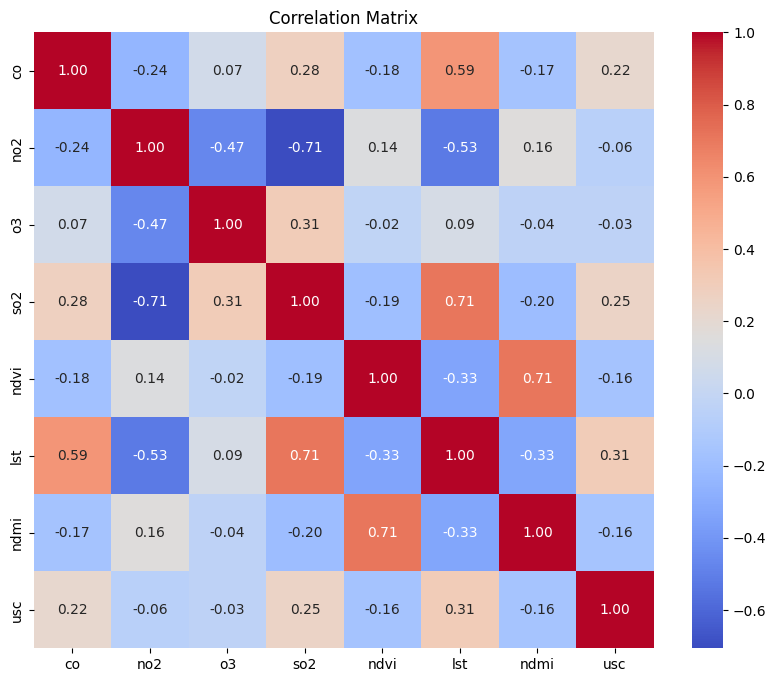

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

year = 2024
week_number = 10
file_path ='G:/My Drive/geepy_hex150/'+str(year) + "-" + str(week_number)+"_temp" + '.csv'

# อ่านไฟล์ CSV เข้าไปใน DataFrame
df = pd.read_csv(file_path)

# คอลัมน์ที่สนใจสำหรับการวิเคราะห์ความสัมพันธ์
columns_of_interest = ['co', 'no2', 'o3', 'so2','ndvi','lst','ndmi','usc']

# คำนวณเมทริกซ์ความสัมพันธ์
correlation_matrix = df[columns_of_interest].corr()

# แสดงเมทริกซ์ความสัมพันธ์
print(correlation_matrix)


# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()